# (12) Cos sim -- awake vs. anesth

**Motivation**: Plot cosine similarity heatmap. <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display, Latex

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = os.path.join(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()



In [2]:
def default_props_anesth(
        num_k: int = 7,
        perc: int = 15,
        **kwargs, ):
    mice = Mice(512)
    props_base = {
        'mice': mice,
        'num_k': num_k,
        'task': 'rest',
        'perc': f'p{perc}-sample',
        'metric': 'pearson',
        'sv_props': {
            'match_using': 'gam',
            'match_metric': 'euclidean'},
        'graph_type': 'real',
        'kw_kmeans': {'n_init': 100},
        'verbose': False,
    }
    kwargs = setup_kwargs(props_base, kwargs)
    props_ca = {'mode': 'ca2', **kwargs}
    return mice, props_ca


def default_props_awake(
        num_k: int = 7,
        perc: int = 15,
        **kwargs, ):
    mice = Mice(Config(
        nn=512,
        sub_ids=[2, 6, 7, 9, 10],
        ses_ids=[4],
        run_ids=range(1, 10 + 1),
    ))
    props_base = {
        'mice': mice,
        'num_k': num_k,
        'task': 'rest',
        'perc': f'p{perc}-sample',
        'metric': 'pearson',
        'sv_props': {
            'match_using': 'gam',
            'match_metric': 'euclidean'},
        'graph_type': 'real',
        'kw_kmeans': {'n_init': 100},
        'verbose': False,
    }
    kwargs = setup_kwargs(props_base, kwargs)
    props_ca = {'mode': 'ca2', **kwargs}
    return mice, props_ca

## Prep

In [3]:
bs = Base(Mice(512), mode='ca2')
kws_show = show_kws(7)
bands = {
    (0.0, 5.0): 'Unfiltered',
    (0.01, 5.0): 'HP',
    (0.01, 0.5): CAS,
    (0.5, 5.0): CAF,
}
fig_dir = pjoin(fig_base_dir, 'rebuttal')
print(fig_dir)

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/rebuttal

## Awake

In [4]:
mice_awake, _ = default_props_awake()

results = {}
for b in bands:
    mice_awake.set_kws(band_ca2=b, desc_ca2='awake', task='rest')
    gr = Group(mice=mice_awake, mode='ca2', perc='p15-sample', num_k=7)
    results[f"{bands[b]}\n{b}"] = gr.avg(ndim_start=1)
results_avg = {
    k: avg(v) for k, v
    in results.items()
}

In [5]:
src_key = (0.0, 5.0)
src_key = '\n'.join([
    bands[src_key],
    str(src_key),
])
global_order = 'infer'
match_metric = 'correlation'

gmap = find_best_mappings(
    data=results_avg,
    centroids=results_avg[src_key],
    match_metric=match_metric,
    global_order=global_order[0],
)

awake = {
    k: v[:, list(gmap[k].values()), :]
    for k, v in results.items()
}
awake = {
    f"Awake\n{k}": v for
    k, v in awake.items()
}
awake_avg = {
    k: avg(v) for k, v
    in awake.items()
}

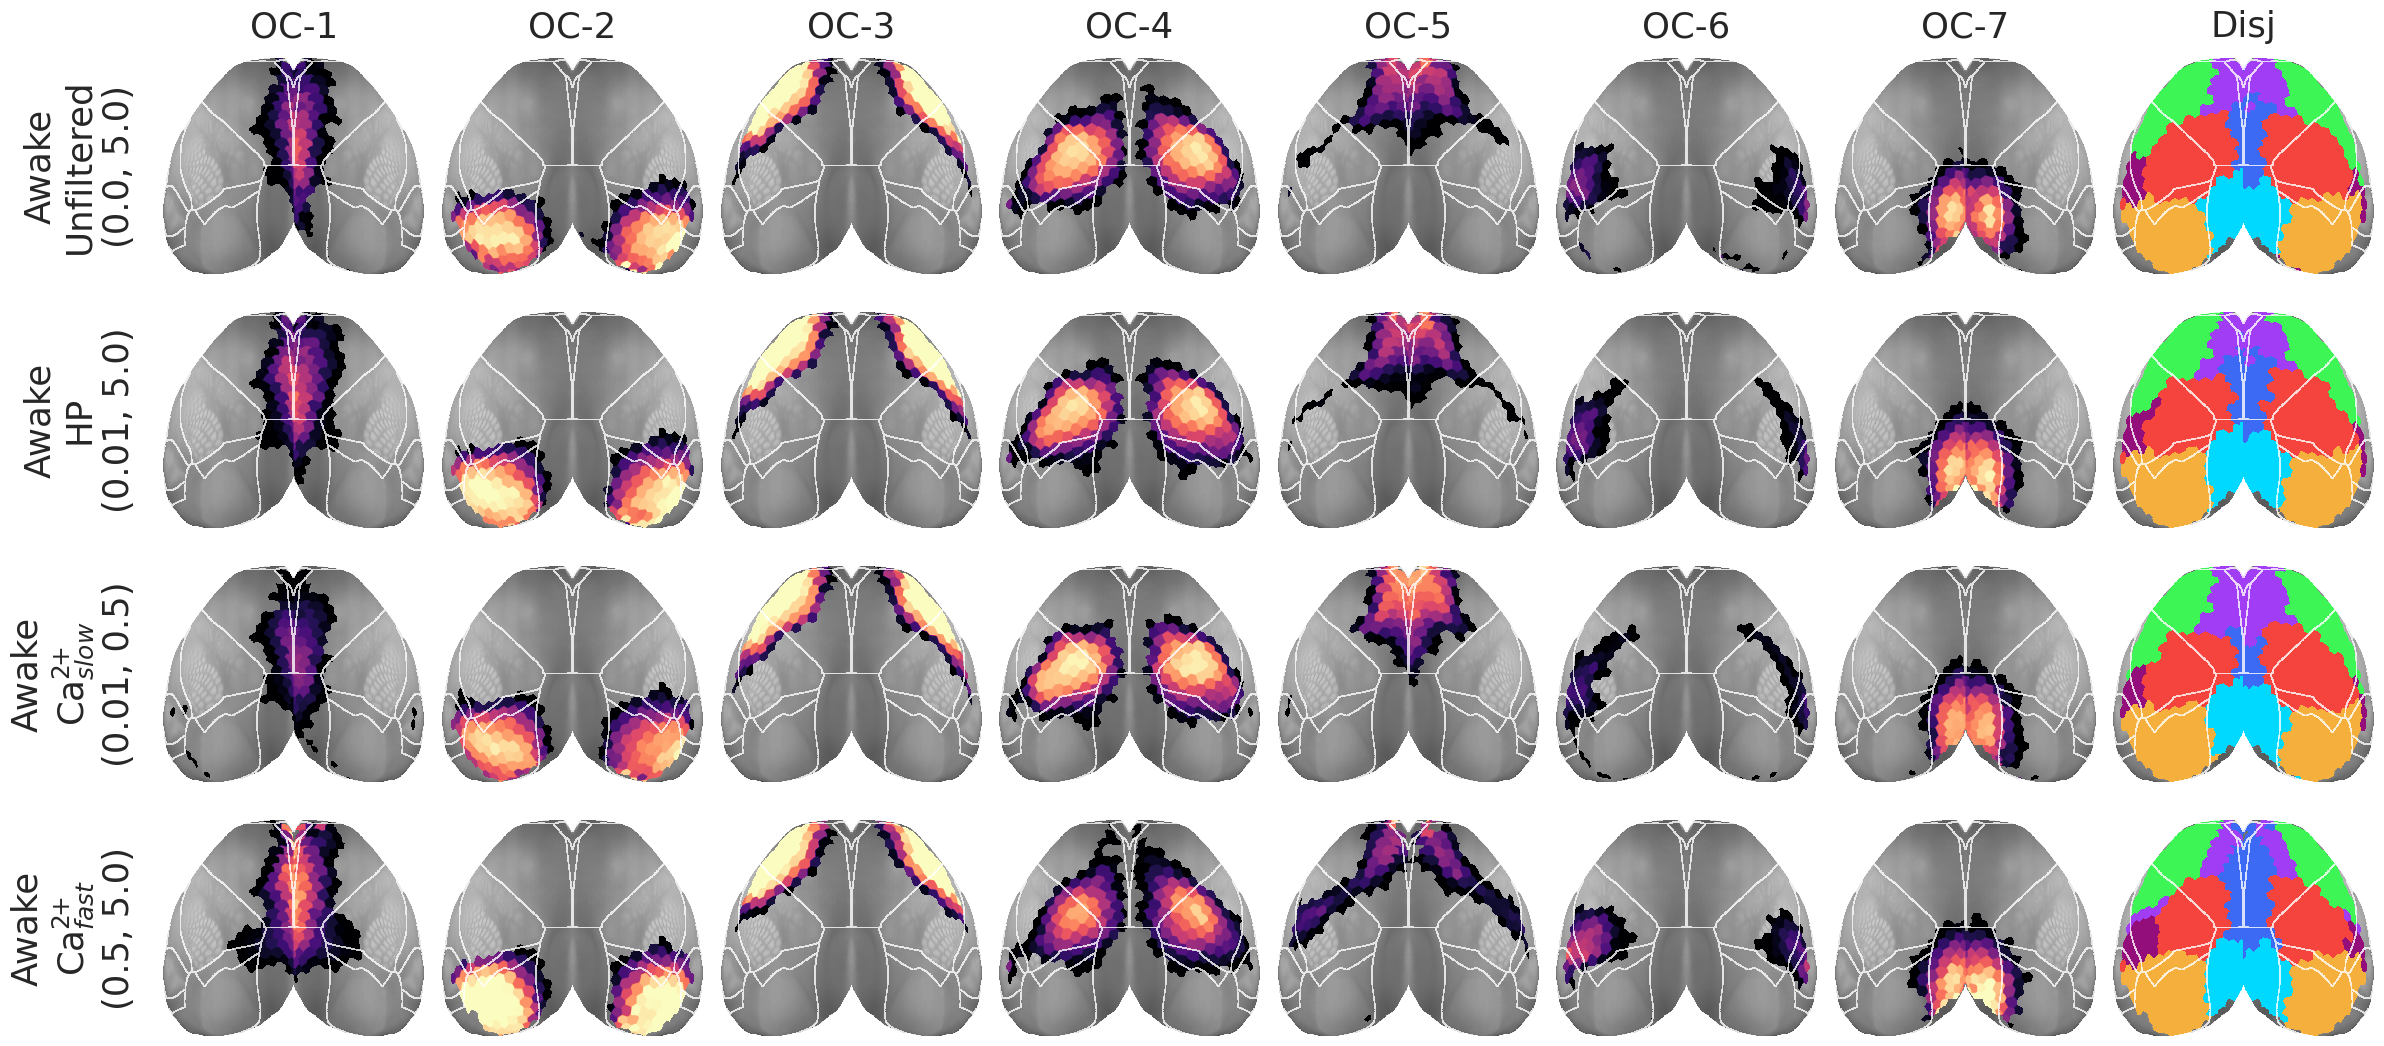

In [6]:
fig, axes = bs.show(awake, **kws_show)

## Anesth

In [7]:
mice_anesth, _ = default_props_anesth()

results = {}
for b in bands:
    mice_anesth.set_kws(band_ca2=b, desc_ca2='preproc', task='rest')
    gr = Group(mice=mice_anesth, mode='ca2', perc='p15-sample', num_k=7)
    results[f"{bands[b]}\n{b}"] = gr.avg(ndim_start=1)
results_avg = {
    k: avg(v) for k, v
    in results.items()
}

### get gmap

In [8]:
src_key = (0.01, 0.5)
src_key = '\n'.join([
    bands[src_key],
    str(src_key),
])
global_order = 'infer'
match_metric = 'correlation'
final_perm = {4: 5, 5: 6, 6: 4}
final_perm = {
    i: final_perm.get(i, i) for
    i in range(7)
}

gmap = find_best_mappings(
    data=results_avg,
    centroids=results_avg[src_key],
    match_metric=match_metric,
    global_order=global_order[0],
)
if final_perm:
    for k, v in gmap.items():
        gmap[k] = {
            s: v[t] for s, t in
            final_perm.items()
        }
    gmap = {
        k: gmap.get(k, final_perm)
        for k in results_avg
    }
# CAF:
_perm = {3: 5, 5: 3}
_perm = {
    i: _perm.get(i, i) for
    i in range(7)
}
k = next(
    k for k in gmap if
    '(0.5, 5.0)' in k
)
gmap[k] = {
    s: gmap[k][t] for
    s, t in _perm.items()
} 

### apply gmap

In [9]:
anesth = {
    k: v[:, list(gmap[k].values()), :]
    for k, v in results.items()
}
anesth = {
    f"Anesth\n{k}": v for
    k, v in anesth.items()
}
anesth_avg = {
    k: avg(v) for k, v
    in anesth.items()
}

### show

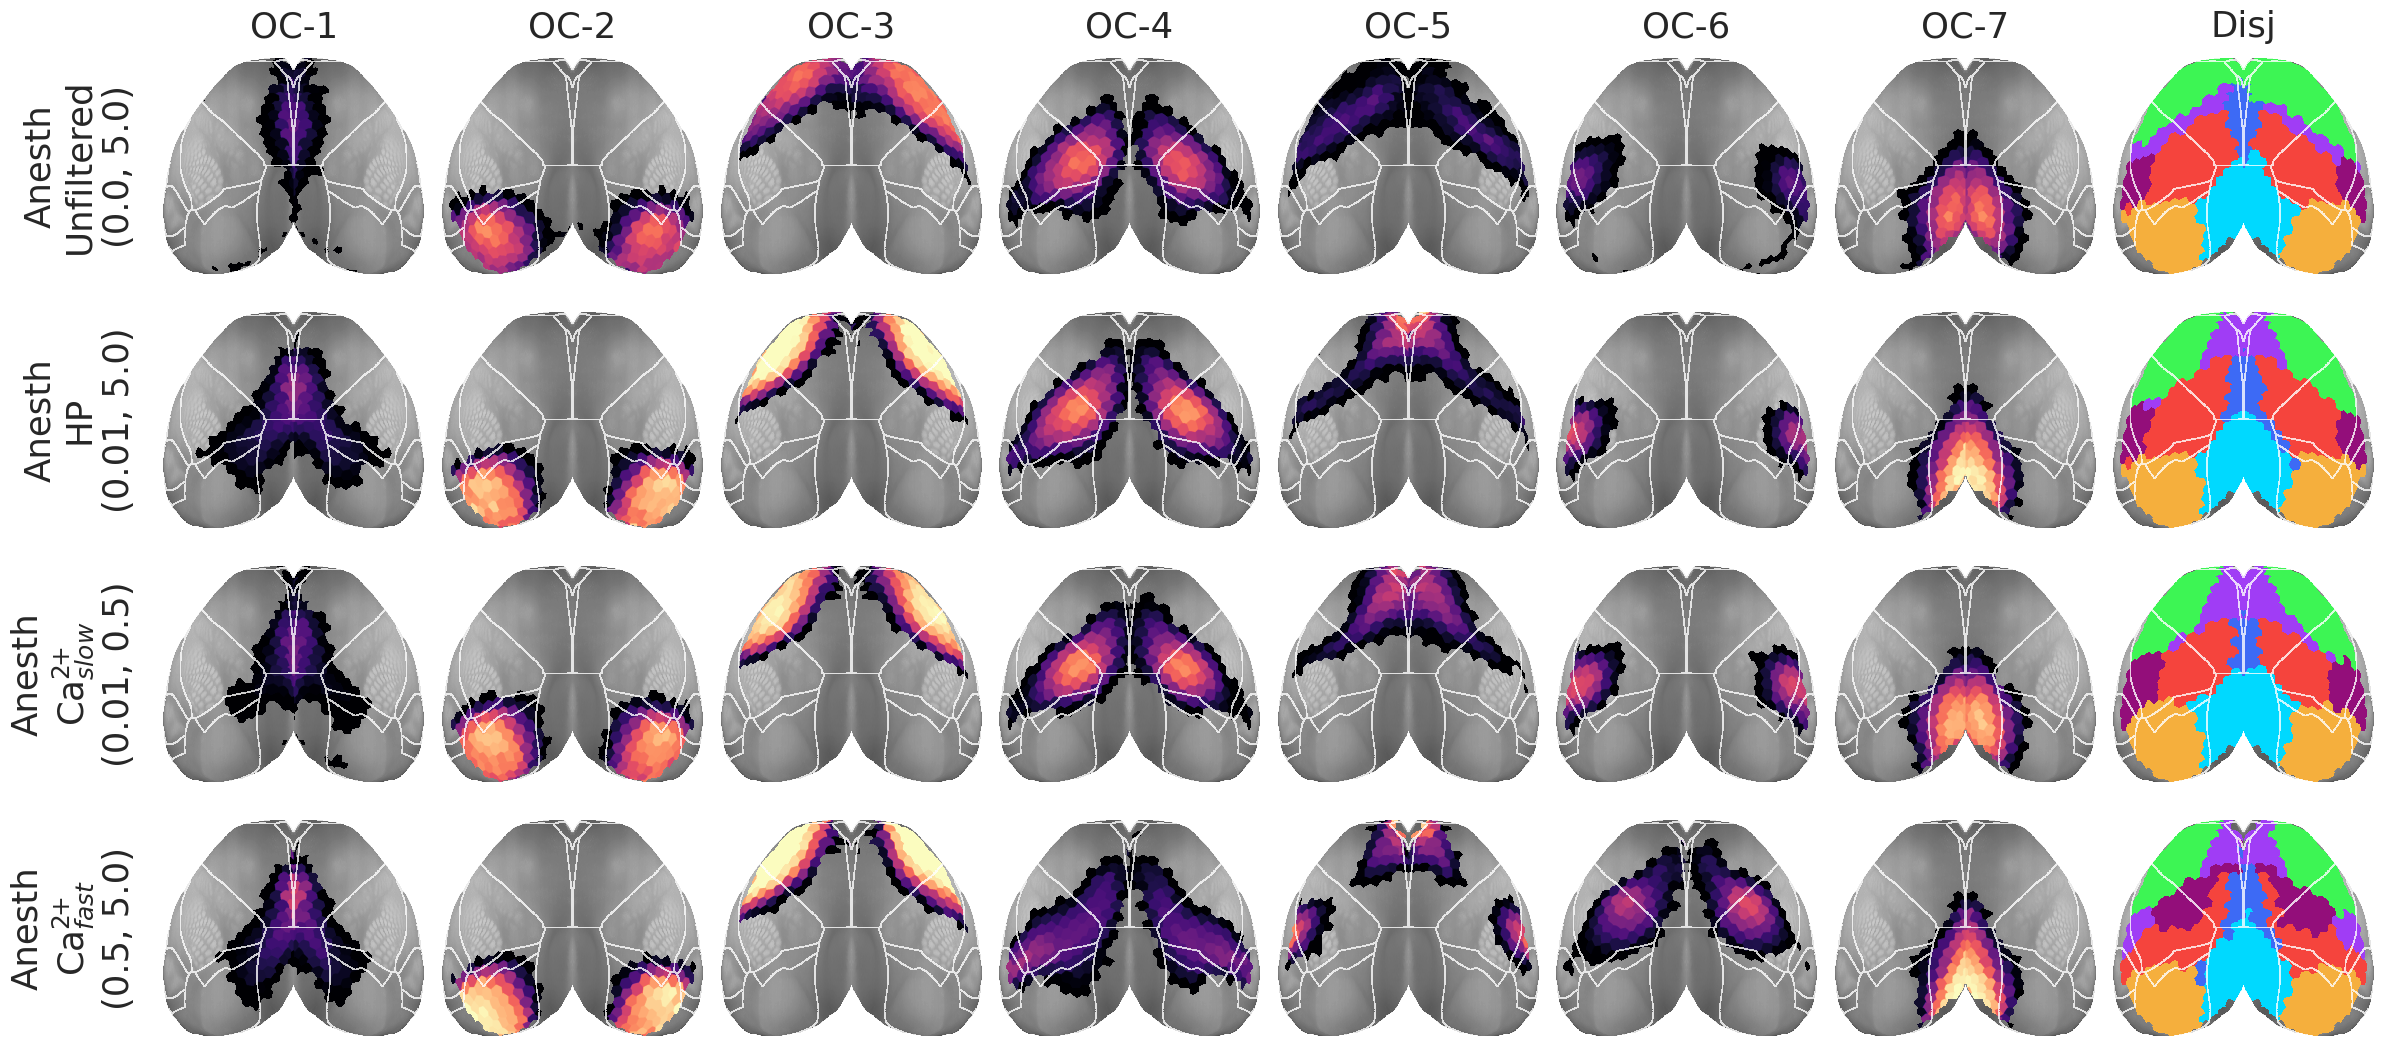

In [10]:
fig, axes = bs.show(anesth, **kws_show)

### Anesth (matching animals)

In [11]:
mice_awake.cfg.sub_ids

[2, 6, 7, 9, 10]

In [12]:
anesth_matched = {
    k: v[np.array(mice_awake.cfg.sub_ids) - 1]
    for k, v in anesth.items()
}
anesth_matched_avg = {
    k: avg(v) for k, v in
    anesth_matched.items()
}

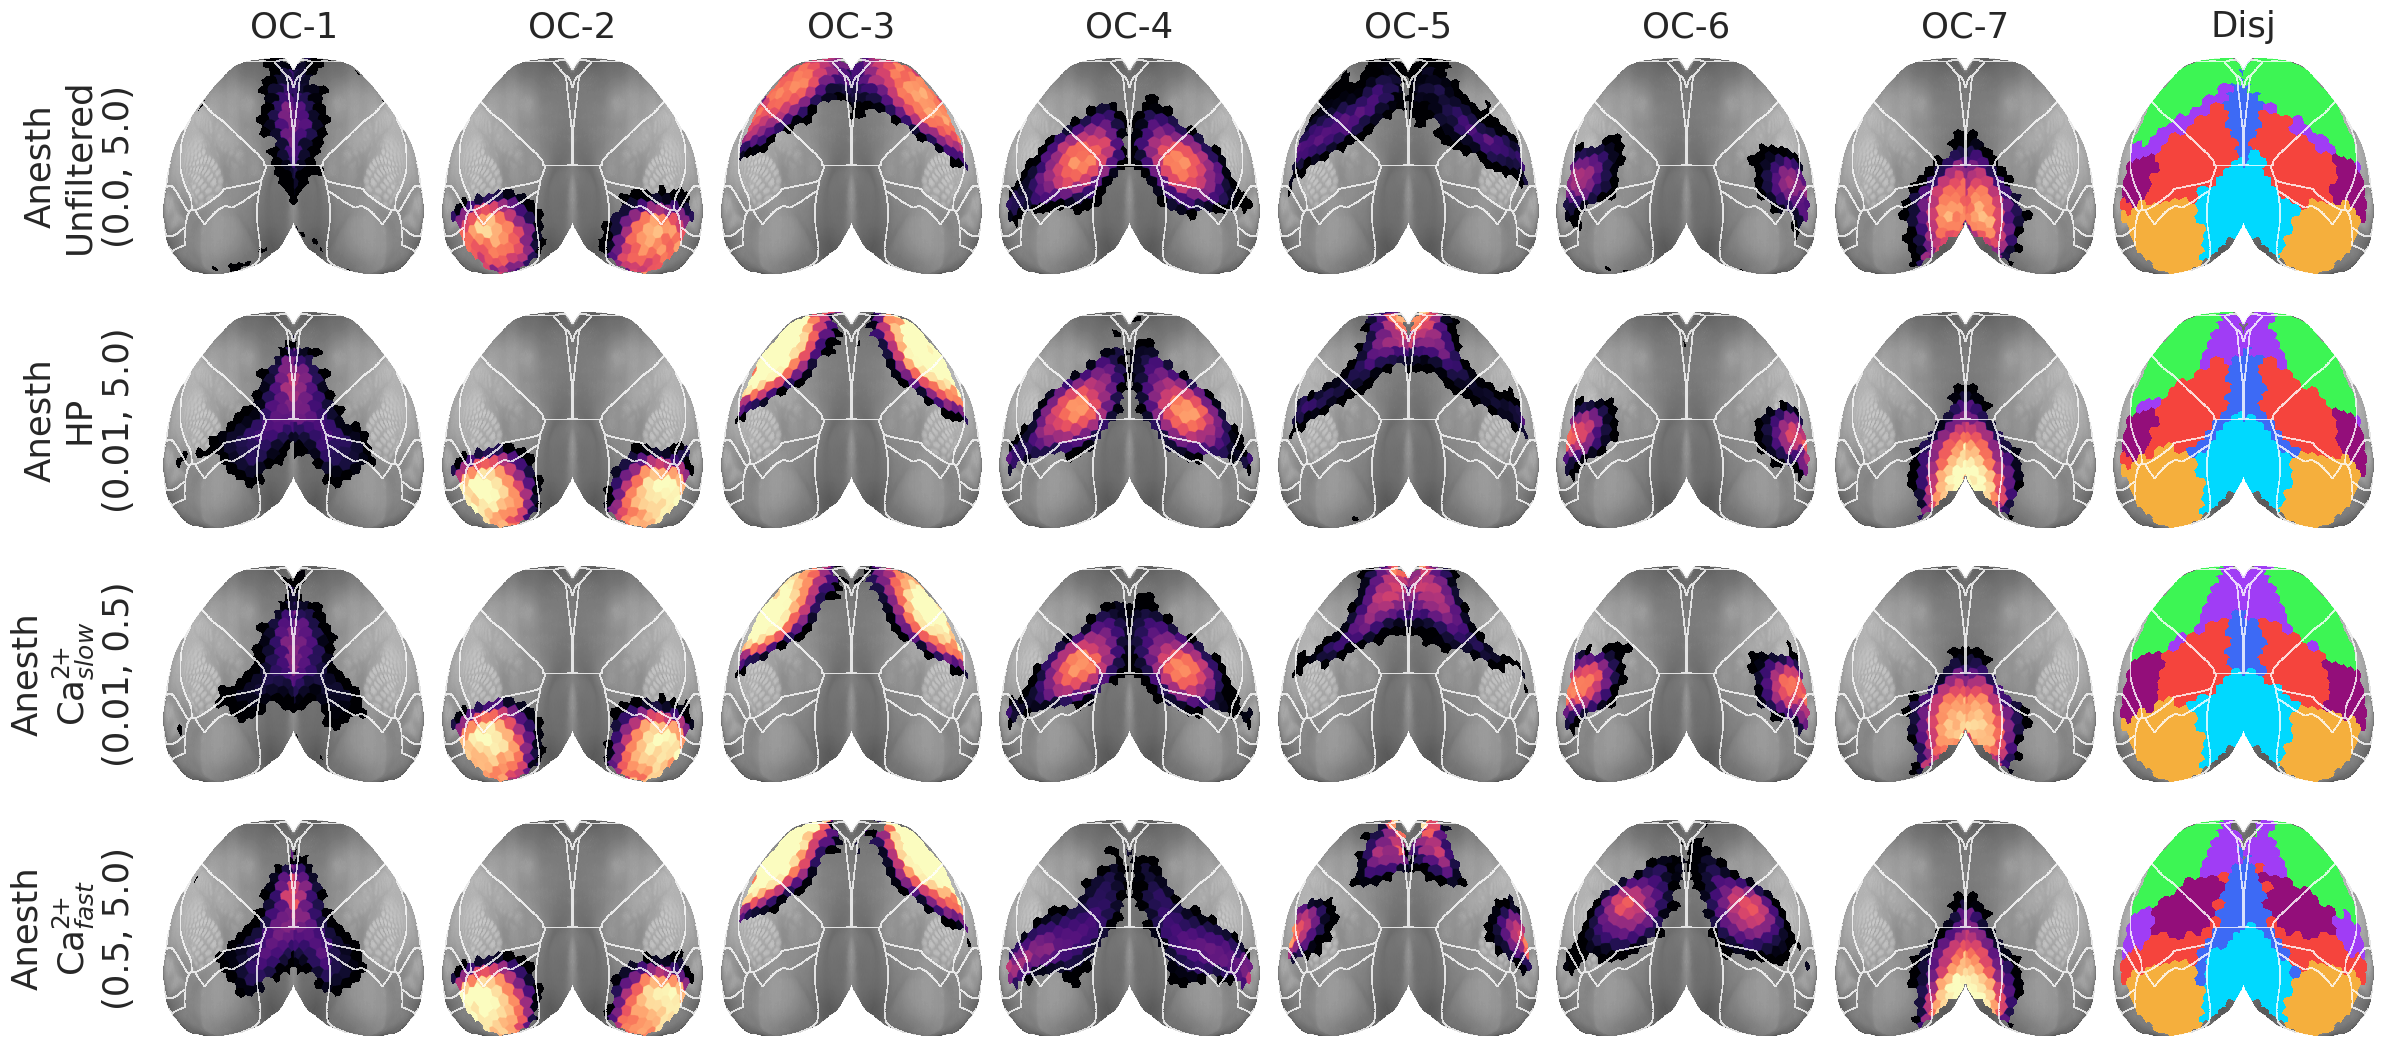

In [13]:
fig, axes = bs.show(anesth_matched_avg, **kws_show)

## Cos. sim.

In [14]:
sim, sim_overall = cosine_sim({**awake, **anesth_matched})

In [15]:
for (k1, k2), v in sim_overall.items():
    c1 = k1.replace('\\!\\!', '')
    c2 = k2.replace('\\!\\!', '')
    msg = ','.join([
        f"{c1} $\,\,$ vs. $\,\,$ {c2} ",
        f"$\quad$ cos sim = {v.mean():0.3f}",
    ])
    display(Latex(msg))
    # print(f"{k1}\n\nvs.\n\n{k2}:\n\noverall cosine sim = {v.mean():0.3f}")
    # print('\n\n' + 50 * '-' + '\n')

### Print cross-cond only

In [16]:
for (k1, k2), v in sim_overall.items():
    if k1.split('\n')[0] == k2.split('\n')[0]:
        continue
    c1 = k1.replace('\\!\\!', '')
    c2 = k2.replace('\\!\\!', '')
    msg = ','.join([
        f"{c1} $\,\,$ vs. $\,\,$ {c2} ",
        f"$\quad$ cos sim overall = {v.mean():0.3f}",
    ])
    display(Latex(msg))

In [18]:
for (k1, k2), v in sim.items():
    if k1.split('\n')[0] == k2.split('\n')[0]:
        continue
    c1 = k1.replace('\\!\\!', '')
    c2 = k2.replace('\\!\\!', '')
    val = ', '.join([
        f"{e:0.3f}" for e in
        np.diagonal(v.mean(0))
    ])
    val = ', '.join([
        f"OC-{i+1}: {e:0.2f}" for i, e in
        enumerate(np.diagonal(v.mean(0)))
    ])
    msg = ','.join([
        f"{c1} $\,$ vs. $\,$ {c2} ",
        f"$\quad$ sim = [{val}]",
    ])
    display(Latex(msg))